In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

In [16]:
# Step 1: Drop Unnecessary Columns

# Columns to drop:
# - 'id': Unique identifier for each listing, not informative for analysis. 
# - 'host id': Unique identifier for each host, not informative for analysis. Max repeated 2x
# - 'name': Listing names are textual and not useful for numerical analysis.
# - 'host name': Host names are irrelevant for our analysis.
# - 'license': Very few listings have a value for license (only 2 non-null values).
# - 'country': All listings are for New York City
# - 'country code': Similar to 'country', this column is not needed.
# - 'House rules: 50%+ are missing'

# Import data
df = pd.read_csv('../data/Airbnb_Open_Data.csv')

df_cleaned = df.drop(columns=['id', 'host id', 'NAME', 'host name', 'license', 'country', 'country code','house_rules'])

# Checking the resulting dataframe structure
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   host_identity_verified          102310 non-null  object 
 1   neighbourhood group             102570 non-null  object 
 2   neighbourhood                   102583 non-null  object 
 3   lat                             102591 non-null  float64
 4   long                            102591 non-null  float64
 5   instant_bookable                102494 non-null  object 
 6   cancellation_policy             102523 non-null  object 
 7   room type                       102599 non-null  object 
 8   Construction year               102385 non-null  float64
 9   price                           102352 non-null  object 
 10  service fee                     102326 non-null  object 
 11  minimum nights                  102190 non-null  float64
 12  number of review

/var/folders/k6/97s742cj1sxgx6xqkr3d9dbr0000gn/T/ipykernel_86864/1518325770.py:14: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/Airbnb_Open_Data.csv')


In [17]:
# Checking the proportion of missing values in each column
missing_values = df_cleaned.isnull().mean().sort_values(ascending=False)
missing_values

last review                       0.154904
reviews per month                 0.154768
availability 365                  0.004367
minimum nights                    0.003986
review rate number                0.003177
calculated host listings count    0.003109
host_identity_verified            0.002817
service fee                       0.002661
price                             0.002407
Construction year                 0.002086
number of reviews                 0.001784
instant_bookable                  0.001023
cancellation_policy               0.000741
neighbourhood group               0.000283
neighbourhood                     0.000156
long                              0.000078
lat                               0.000078
room type                         0.000000
dtype: float64

In [18]:
# Step 2: Handle Missing Values

# Fill missing values in 'reviews per month' with 0
df_cleaned['reviews per month'] = df_cleaned['reviews per month'].fillna(0)

# Convert 'last review' to datetime and fill missing values with the earliest date
df_cleaned['last review'] = pd.to_datetime(df_cleaned['last review'], errors='coerce')
earliest_date = df_cleaned['last review'].min()
df_cleaned['last review'] = df_cleaned['last review'].fillna(earliest_date)

# Identify numerical and categorical columns
num_columns = df_cleaned.select_dtypes(include=['float64']).columns.tolist()
cat_columns = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Fill missing numerical columns with median
for col in num_columns:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Fill missing categorical columns with mode
for col in cat_columns:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# Convert specified columns to integers
int_columns = ['minimum nights', 'number of reviews', 'review rate number', 'calculated host listings count']
for col in int_columns:
    df_cleaned[col] = df_cleaned[col].astype(int)

# Clean 'price' and 'service fee' columns
df_cleaned['price'] = df_cleaned['price'].astype(str).replace(r'[\$,]', '', regex=True).astype(float)
df_cleaned['service fee'] = df_cleaned['service fee'].astype(str).replace(r'[\$,]', '', regex=True).astype(float)

# Step 3: Encode Categorical Variables

# One-hot encode smaller categorical variables
small_categorical_cols = ['host_identity_verified', 'room type', 'cancellation_policy', 'instant_bookable', 'neighbourhood group']
df_encoded = pd.get_dummies(df_cleaned, columns=small_categorical_cols, drop_first=True)

# Integer encode 'neighbourhood'
le = LabelEncoder()
df_encoded['neighbourhood_encoded'] = le.fit_transform(df_encoded['neighbourhood'])
df_encoded.drop('neighbourhood', axis=1, inplace=True)

# Step 4: Apply Log Transformation and Standardization

# Apply log transformation to skewed numerical features
df_encoded['minimum nights'] = np.log1p(df_encoded['minimum nights'])
df_encoded['availability 365'] = np.log1p(df_encoded['availability 365'])
df_encoded['number of reviews'] = np.log1p(df_encoded['number of reviews'])

# Replace any infinite values resulting from log transformation
df_encoded['minimum nights'] = df_encoded['minimum nights'].replace([np.inf, -np.inf], np.nan).fillna(df_encoded['minimum nights'].median())
df_encoded['availability 365'] = df_encoded['availability 365'].replace([np.inf, -np.inf], np.nan).fillna(df_encoded['availability 365'].median())
df_encoded['number of reviews'] = df_encoded['number of reviews'].replace([np.inf, -np.inf], np.nan).fillna(df_encoded['number of reviews'].median())

# Update list of numerical columns (excluding 'price' if it's your target variable)
numerical_cols = ['service fee', 'minimum nights', 'availability 365', 'number of reviews', 'neighbourhood_encoded']

# Standardize numerical features
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Final Data Check
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   lat                                102599 non-null  float64       
 1   long                               102599 non-null  float64       
 2   Construction year                  102599 non-null  float64       
 3   price                              102599 non-null  float64       
 4   service fee                        102599 non-null  float64       
 5   minimum nights                     102599 non-null  float64       
 6   number of reviews                  102599 non-null  float64       
 7   last review                        102599 non-null  datetime64[ns]
 8   reviews per month                  102599 non-null  float64       
 9   review rate number                 102599 non-null  int64         
 10  calculated host list

/Users/ericgulottyjr/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ericgulottyjr/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
df_encoded.head()

,lat,long,Construction year,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,...,cancellation_policy_moderate,cancellation_policy_strict,instant_bookable_True,neighbourhood group_Brooklyn,neighbourhood group_Manhattan,neighbourhood group_Queens,neighbourhood group_Staten Island,neighbourhood group_brookln,neighbourhood group_manhatan,neighbourhood_encoded
0,40.64749,-73.97237,2020.0,966.0,1.027392,0.875347,0.058772,2021-10-19,0.21,4,...,False,True,False,True,False,False,False,False,False,0.037953
1,40.75362,-73.98377,2007.0,142.0,-1.458356,1.982159,1.036858,2022-05-21,0.38,4,...,True,False,False,False,True,False,False,False,False,0.311190
2,40.80902,-73.94190,2005.0,620.0,-0.012102,-0.205302,-1.417008,2012-07-11,0.00,5,...,False,False,True,False,True,False,False,False,False,-0.163379
3,40.68514,-73.95976,2005.0,368.0,-0.765359,1.982159,2.173521,2019-07-05,4.64,4,...,True,False,True,True,False,False,False,False,False,-0.954328
4,40.79851,-73.94399,2009.0,204.0,-1.262509,0.875347,0.058772,2018-11-19,0.10,3,...,True,False,False,False,True,False,False,False,False,-0.666710


/Users/ericgulottyjr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ericgulottyjr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ericgulottyjr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ericgulottyjr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

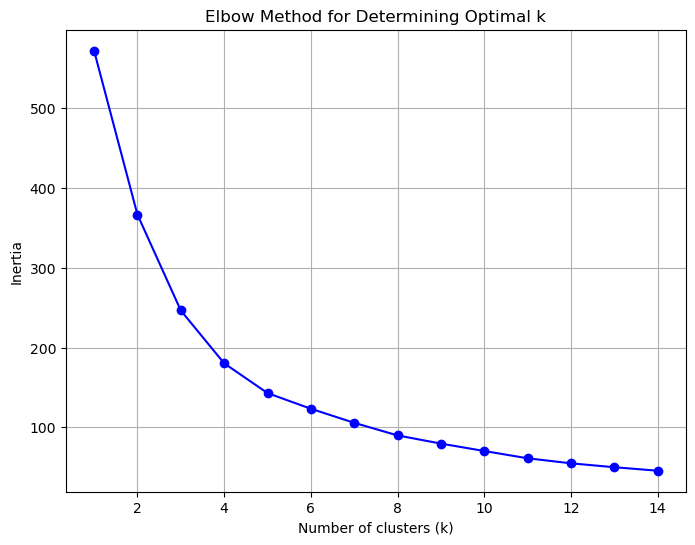

/Users/ericgulottyjr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
# Step 1: Determine the optimal number of clusters using the elbow method
inertia = []
K = range(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_encoded[['lat', 'long']])
    inertia.append(kmeans.inertia_)

# Step 2: Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Determining Optimal k')
plt.grid(True)
plt.show()

# Step 3: Interpret the elbow plot and set k_optimal
k_optimal = 5  # Adjust based on your elbow plot

# Step 4: Apply KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df_encoded['location_cluster'] = kmeans.fit_predict(df_encoded[['lat', 'long']])

# One-hot encode the clusters
df_encoded = pd.get_dummies(df_encoded, columns=['location_cluster'], prefix='cluster')

# Drop 'lat' and 'long' if no longer needed
df_encoded.drop(['lat', 'long'], axis=1, inplace=True)

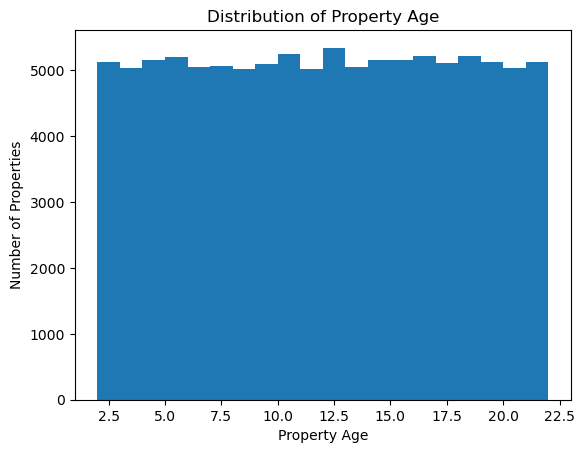

Bins after sorting and removing duplicates: [0, 5, 10, 15, 22]
Number of bins: 5
Number of labels: 4
age_category
16-21 years    30848
11-15 years    25742
6-10 years     25477
0-5 years      20532
Name: count, dtype: int64


In [21]:
# Step 1: Calculate property age
current_year = pd.Timestamp.now().year
df_encoded['property_age'] = current_year - df_encoded['Construction year']
df_encoded['property_age'] = df_encoded['property_age'].apply(lambda x: x if x > 0 else 0)

# Optional: Visualize the distribution
import matplotlib.pyplot as plt

plt.hist(df_encoded['property_age'], bins=range(int(df_encoded['property_age'].min()), int(df_encoded['property_age'].max()) + 2))
plt.xlabel('Property Age')
plt.ylabel('Number of Properties')
plt.title('Distribution of Property Age')
plt.show()

# Step 2: Define bins and labels based on the data
bins = [0, 5, 10, 15, 22]  # Adjusted to [0, 5, 10, 15, 22]
labels = ['0-5 years', '6-10 years', '11-15 years', '16-21 years']

# Ensure bins are unique and sorted
bins = sorted(set(bins))
print("Bins after sorting and removing duplicates:", bins)
print("Number of bins:", len(bins))
print("Number of labels:", len(labels))

# Step 3: Create binned feature
df_encoded['age_category'] = pd.cut(
    df_encoded['property_age'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Optional: Check the distribution of the new feature
print(df_encoded['age_category'].value_counts())

# Step 4: One-hot encode the new categorical feature
df_encoded = pd.get_dummies(df_encoded, columns=['age_category'], drop_first=True)

# Step 5: Drop 'Construction year' and 'property_age' if not needed
df_encoded.drop(['Construction year', 'property_age'], axis=1, inplace=True)

In [22]:
# Convert 'last review' to datetime
df_encoded['last review'] = pd.to_datetime(df_encoded['last review'], errors='coerce')

# Calculate days since last review
df_encoded['days_since_last_review'] = (pd.Timestamp('today') - df_encoded['last review']).dt.days

# Fill missing values with a large number (e.g., max days)
max_days = df_encoded['days_since_last_review'].max()
df_encoded['days_since_last_review'] = df_encoded['days_since_last_review'].fillna(max_days)

# Drop 'last review' if no longer needed
df_encoded.drop('last review', axis=1, inplace=True)

In [23]:
# Initialize scaler
scaler = StandardScaler()

# Standardize numerical features
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# --- Create Interaction Terms ---

# Get the list of one-hot encoded 'neighbourhood group' columns
neighbourhood_group_cols = [col for col in df_encoded.columns if col.startswith('neighbourhood group_')]

# Create interaction terms for each 'neighbourhood group' with 'room type_Private room'
for col in neighbourhood_group_cols:
    if 'room type_Private room' in df_encoded.columns:
        interaction_term = f"{col}_PrivateRoom"
        df_encoded[interaction_term] = df_encoded[col] * df_encoded['room type_Private room']

# --- Final Data Check ---

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 37 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   price                                          102599 non-null  float64
 1   service fee                                    102599 non-null  float64
 2   minimum nights                                 102599 non-null  float64
 3   number of reviews                              102599 non-null  float64
 4   reviews per month                              102599 non-null  float64
 5   review rate number                             102599 non-null  int64  
 6   calculated host listings count                 102599 non-null  int64  
 7   availability 365                               102599 non-null  float64
 8   host_identity_verified_verified                102599 non-null  bool   
 9   room type_Hotel room                 

In [24]:
df_encoded.head()

,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365,host_identity_verified_verified,room type_Hotel room,...,age_category_6-10 years,age_category_11-15 years,age_category_16-21 years,days_since_last_review,neighbourhood group_Brooklyn_PrivateRoom,neighbourhood group_Manhattan_PrivateRoom,neighbourhood group_Queens_PrivateRoom,neighbourhood group_Staten Island_PrivateRoom,neighbourhood group_brookln_PrivateRoom,neighbourhood group_manhatan_PrivateRoom
0,966.0,1.027392,0.875347,0.058772,0.21,4,6,0.873787,False,False,...,False,False,False,1147,True,False,False,False,False,False
1,142.0,-1.458356,1.982159,1.036858,0.38,4,2,0.773941,True,False,...,False,False,True,933,False,False,False,False,False,False
2,620.0,-0.012102,-0.205302,-1.417008,0.00,5,1,0.965331,False,False,...,False,False,True,4534,False,True,False,False,False,False
3,368.0,-0.765359,1.982159,2.173521,4.64,4,1,0.926050,False,False,...,False,False,True,1984,False,False,False,False,False,False
4,204.0,-1.262509,0.875347,0.058772,0.10,3,1,0.878387,True,False,...,False,True,False,2212,False,False,False,False,False,False


In [25]:
df_encoded.to_csv('../processed_data/encoded_data.csv')